First we install keras-tuner and suppress output

In [12]:
!pip install keras-tuner &>/dev/null

Then we import basic libraries and set basic quantities for this learning task

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
#%cd /content/drive/MyDrive/Colab Notebooks/LAB_mod_B/Ex1/Git

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
# default font
plt.rcParams['font.size'] = 13

# number of data points, i.e., database size
N=2000
# size of each sample
L=8
# box size
B=10

!mkdir DATA

%run useful.py

mkdir: cannot create directory ‘DATA’: File exists


## Creation of data
The following cell creates the dataset and plots it

2 5 1


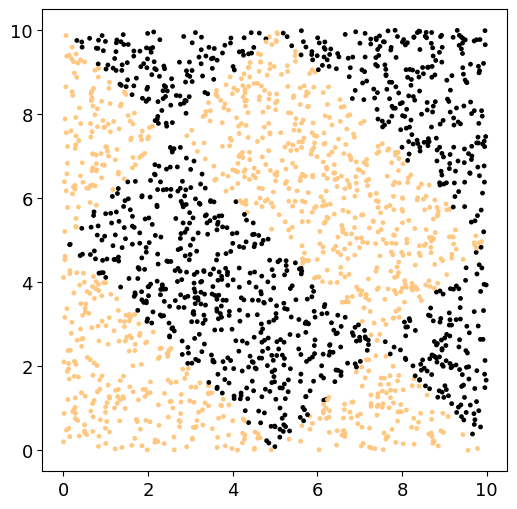

./DATA/data-for-DNN_type3_L8.dat
./DATA/labels-for-DNN_type3_L8.dat


In [16]:
TYPE=3

# random seed for reproducibility
np.random.seed(12345)
print(np.random.randint(0,10),np.random.randint(0,10),np.random.randint(0,10))

x,y = (np.random.random((N,L)))*B, np.zeros(N)
for i in range(N):
    # label data according to a nonlinear function "f"
    y[i] = NF(x[i],B,TYPE)

plot_data(x,y)

fn=filename("data",L,TYPE)
np.savetxt(fn,x)
print(fn)
fn=filename("labels",L,TYPE)
np.savetxt(fn,y,fmt="%d")
print(fn)

# Analysis with Keras of 2D data

In [17]:
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Dropout
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

import matplotlib as mpl
import matplotlib.pyplot as plt
# default font
plt.rcParams['font.size'] = 13

from sklearn.preprocessing import StandardScaler

%run useful.py

# training data
perc_train = 0.7
perc_test = 0.15
perc_valid = 0.15

<Figure size 640x480 with 0 Axes>

## Read data

In [18]:
# Keras works with numpy arrays: just use them from the start

TYPE=3
# data point size
L=8
# span of each component
B=10
x = np.loadtxt(filename("data",L,TYPE), delimiter=' ')
y = np.loadtxt(filename("labels",L,TYPE), delimiter=' ')
y = y.astype("int")
#print(x.shape)
N = len(x)
# average and std.dev.
x_mean = np.mean(x,axis=0)
x_std  = np.std(x,axis=0)


# dim. of a sample
L = len(x[0])

# number of samples in each set
N_train = int(perc_train * N)
N_test = int(perc_test * N)
N_valid = int(perc_valid * N)


## Standardize data

In [19]:
print("before rescaling:\nmean value=", x_mean,"\nstd. dev.=",x_std)
def Standardize(x,m,s):
    """
    rescale each component using its mean and standard deviation
    """
    N = len(x)
    # assuming len(m)=len(s)=len(x[0])
    mm,ss = np.tile(m,(N,1)), np.tile(s,(N,1))
    return (x-mm)/ss
x = Standardize(x,x_mean,x_std)
print("after rescaling:\nmean value=", x.mean(axis=0),"\nstd. dev.=",x.std(axis=0))

before rescaling:
mean value= [5.01860571 5.01726228 5.02153857 5.08947968 5.10248206 5.03670082
 4.88645281 5.05411547] 
std. dev.= [2.86912607 2.89535235 2.87312372 2.86324409 2.90278676 2.91948328
 2.92549254 2.89281292]
after rescaling:
mean value= [ 2.53633226e-15  9.27924404e-16 -1.44884105e-15 -2.38371996e-15
 -2.85274582e-15 -2.02196593e-15 -1.09010023e-15 -1.53632662e-15] 
std. dev.= [1. 1. 1. 1. 1. 1. 1. 1.]


## Split train, validation and test data

In [20]:
(x_train, y_train) = (x[0:N_train],y[0:N_train])
(x_valid, y_valid) = (x[N_train:N_train+N_valid],y[N_train:N_train+N_valid])
(x_test, y_test) = (x[N_train+N_valid:],y[N_train+N_valid:])

print("Train:",len(x_train),"points","\t Validation:",len(x_valid),"points","\t Test:",len(x_test),"points\n")

print(f"Train set fraction of datapoints:")
print(f"ones \t zeros")
print(f"{round(len(x_train[y_train == 1])/len(x_train)*100,2)}% \t {round(len(x_train[y_train == 0])/len(x_train)*100,2)}%\n")
print(f"Valid set fraction of datapoints:")
print(f"ones \t zeros")
print(f"{round(len(x_valid[y_valid == 1])/len(x_valid)*100,2)}% \t {round(len(x_valid[y_valid == 0])/len(x_valid)*100,2)}%\n")
print(f"Test set fraction of datapoints:")
print(f"ones \t zeros")
print(f"{round(len(x_test[y_test == 1])/len(x_test)*100,2)}% \t {round(len(x_test[y_test == 0])/len(x_test)*100,2)}%\n")


Train: 1400 points 	 Validation: 300 points 	 Test: 300 points

Train set fraction of datapoints:
ones 	 zeros
49.71% 	 50.29%

Valid set fraction of datapoints:
ones 	 zeros
49.67% 	 50.33%

Test set fraction of datapoints:
ones 	 zeros
48.0% 	 52.0%



## Define model with Keras

Here we define the bulid_model function

In [21]:
def build_model(hp):
    model = Sequential()
    n_hidden_layers = 3

    # input layer
    model.add(Dense(L,input_shape=(L,),activation='relu'))

    # hidden layers
    for i in range(n_hidden_layers):
        model.add(
            Dense(
            20, # num of neurons
            activation = hp.Choice(f"activation_{i}",['relu','tanh','sigmoid','elu'])
            )
        )
        model.add(
            Dropout(
                rate = hp.Float(f"dropout_rate_{i}",min_value=0,max_value=0.3,step=0.1)
            )
        )

    # output layer
    model.add(Dense(1,activation='sigmoid'))

    # choice of optimizer
    optimizer_choice = hp.Choice("optimizer", ['Adam', 'RMSprop', 'Nesterov'])

    # choice of exponent of LR
    exponent_choice = hp.Choice("lr_exponent",[-1,-2,-3,-4,-5,-6])

    # each optimizer has to have a learning rate well-defined
    if optimizer_choice == 'Adam':
        optimizer = Adam(
            learning_rate = 10 ** exponent_choice
        )
    elif optimizer_choice == 'RMSprop':
        optimizer = RMSprop(
            learning_rate = 10 ** exponent_choice
        )
    else:
        optimizer = SGD(
            learning_rate = 10 ** exponent_choice,
            #momentum=hp.Float("momentum", min_value=0.0, max_value=1.0),
            nesterov=True
        )

    # compilation of the model
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

trial = build_model(kt.HyperParameters())
# print a summary of the model
trial.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 8)                   │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 20)                  │             180 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 20)                  │             420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 20)                  │             420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,113 (4.35 KB)

 Trainable params: 1,113 (4.35 KB)

 Non-trainable params: 0 (0.00 B)

## Training

Here we setup the tuner for the RandomSearch. max_trials is number of combinations to try

In [22]:
tuner = kt.RandomSearch(
    hypermodel = build_model,
    objective = "val_accuracy",
    max_trials = 24, # parameters permutations are 240
    executions_per_trial = 1,
)


In [23]:
tuner.search_space_summary()

Search space summary
Default search space size: 8
activation_0 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid', 'elu'], 'ordered': False}
dropout_rate_0 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.3, 'step': 0.1, 'sampling': 'linear'}
activation_1 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid', 'elu'], 'ordered': False}
dropout_rate_1 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.3, 'step': 0.1, 'sampling': 'linear'}
activation_2 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid', 'elu'], 'ordered': False}
dropout_rate_2 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.3, 'step': 0.1, 'sampling': 'linear'}
optimizer (Choice)
{'default': 'Adam', 'conditions': [], 'values': ['Adam', 'RMSprop', 'Nesterov'], 'ordered': False}
lr_exponent (Choice)
{'default': -1, 'conditions': [], 'values': [-1, -2,

In [25]:
nepoch = 400
tuner.search(x_train,y_train,epochs=nepoch,validation_data=(x_valid,y_valid))

Trial 4 Complete [00h 01m 17s]
val_accuracy: 0.5433333516120911

Best val_accuracy So Far: 0.5666666626930237
Total elapsed time: 00h 05m 52s


In [26]:
import pandas as pd

trials = tuner.oracle.trials

results = []
for trial_id, trial in trials.items():
    if "val_accuracy" in trial.metrics.metrics:
        best_val_acc = trial.metrics.metrics["val_accuracy"].get_best_value()
        results.append({
            "trial_id": trial_id,
            "best_val_accuracy": best_val_acc,
            "hyperparameters": trial.hyperparameters.values
        })

df_results = pd.DataFrame(results)
df_results_print = df_results[["trial_id","best_val_accuracy"]]

print(df_results_print.sort_values(by="best_val_accuracy", ascending=False))

  trial_id  best_val_accuracy
2        2           0.566667
3        3           0.543333
1        1           0.540000
0        0           0.503333


In [27]:
thresh = max(df_results["best_val_accuracy"]) - 0.1

selected_results = df_results[df_results["best_val_accuracy"] > thresh]
#print(selected_results['trial_id'])
print('selected models:',len(selected_results))
selected_trial_ids = set(selected_results["trial_id"].tolist())

candidate_models = [entry for entry in results if entry['trial_id'] in selected_trial_ids]
#print(f'\n {candidate_models}')
print('selected models ids:',[entry["trial_id"] for entry in candidate_models])

selected models: 4
selected models ids: ['0', '1', '2', '3']


## Performing K-fold cross validation for each selected model

In [28]:
def create_model(hyperparams):
    model = keras.Sequential()

    # input layer
    model.add(Dense(L,input_shape=(L,),activation='relu'))

    # First layer
    model.add(keras.layers.Dense(20, activation=hyperparams['activation_0']))
    model.add(keras.layers.Dropout(hyperparams['dropout_rate_0']))

    # Second layer
    model.add(keras.layers.Dense(20, activation=hyperparams['activation_1']))
    model.add(keras.layers.Dropout(hyperparams['dropout_rate_1']))

    # Third layer
    model.add(keras.layers.Dense(20, activation=hyperparams['activation_2']))
    model.add(keras.layers.Dropout(hyperparams['dropout_rate_2']))

    # Output layer
    model.add(keras.layers.Dense(1, activation="sigmoid"))


    if hyperparams["optimizer"] == "RMSprop":
        optimizer = keras.optimizers.RMSprop(learning_rate = 10 ** hyperparams["lr_exponent"])#, momentum=hyperparams["momentum"])
    elif hyperparams["optimizer"] == "Adam":
        optimizer = keras.optimizers.Adam(learning_rate = 10 ** hyperparams["lr_exponent"])
    elif hyperparams["optimizer"] == "SGD":
        optimizer = keras.optimizers.SGD(learning_rate = 10 ** hyperparams["lr_exponent"]) #, momentum=hyperparams["momentum"])
    elif hyperparams["optimizer"] == "Nesterov":
        optimizer = keras.optimizers.SGD(learning_rate = 10 ** hyperparams["lr_exponent"]) #, momentum=hyperparams["momentum"])
    else:
        raise ValueError("Unsupported optimizer!")

    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

    return model

In [31]:
from sklearn.model_selection import KFold
import numpy as np
from tensorflow.keras.models import Sequential
import time
from IPython.display import clear_output

k = 5 # number of folds
kfold_nepoch = 400 # number of epoch per each kfold training step
kf = KFold(n_splits = k, shuffle = True, random_state = 42)

# redefining all dataset (Train set + Validation set) to be used for KFold
(x_KF, y_KF) = (x[0:N_train+N_valid],y[0:N_train+N_valid])
print("KFold dataset:",len(x_KF),"points\n")

fold_accuracies = [] # store results

for model in candidate_models:
    #print(candidate_models[int(model["trial_id"])]["hyperparameters"])
    #print(model["trial_id"],model["hyperparameters"])
    hyperparams = model["hyperparameters"]
    #print(hyperparams)
    tbt_model = create_model(hyperparams)

    start_kfold_time = time.time()
    for train_index, val_index in kf.split(x_KF):
        x_train, x_val = x_KF[train_index], x_KF[val_index]
        y_train, y_val = y_KF[train_index], y_KF[val_index]

        tbt_model.fit(x_train, y_train, epochs = kfold_nepoch, batch_size = 32, verbose = 0)

        val_loss, val_acc = tbt_model.evaluate(x_val, y_val, verbose = 0)
        fold_accuracies.append(val_acc)
        print(f"Fold {len(fold_accuracies)} accuracy: {val_acc:.4f}")


    mean_acc = np.mean(fold_accuracies)
    std_acc = np.std(fold_accuracies)
    model["k_fold_val_acc"] = mean_acc
    model["k_fold_val_acc_error"] = std_acc

    #non vanno - cambiare " in '
    #print(f"\nModel {model["trial_id"]} K-fold training took {round(time.time()-start_kfold_time,2)}s")
    #print(f"Results for model index {model["trial_id"]}, accuracy = {round(mean_acc,2)} +- {round(std_acc,2)}\n")
    time.sleep(5)
    clear_output()

    fold_accuracies = []
clear_output()
print(f"Training complete! Trained {len(candidate_models)} models")

Training complete! Trained 4 models


## Final training
In the end we find the best model and we train it on the whole train + valid dataset, testing on the test set

In [32]:
max_acc = 0
best_model = None

for model in candidate_models:
    if model['k_fold_val_acc'] > max_acc:
        max_acc = model['k_fold_val_acc']
        best_model = model

print(f"best model according to k-fold is model index {best_model['trial_id']}")
print(f"accuracy: {round(best_model['k_fold_val_acc'],3)} +- {round(best_model['k_fold_val_acc_error'],3)}")
print(f"params:")
print(best_model["hyperparameters"])

best model according to k-fold is model index 3
accuracy: 0.525 +- 0.029
params:
{'activation_0': 'tanh', 'dropout_rate_0': 0.0, 'activation_1': 'sigmoid', 'dropout_rate_1': 0.1, 'activation_2': 'sigmoid', 'dropout_rate_2': 0.2, 'optimizer': 'RMSprop', 'lr_exponent': -5}


In [33]:
final_model = create_model(best_model['hyperparameters'])
final_model.fit(x_KF,y_KF,epochs = nepoch, batch_size = 32, verbose = 0)
final_loss, final_acc = final_model.evaluate(x_test, y_test)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5483 - loss: 0.6914  


## 2) Data augmentation

1) prendo i dati originali
2) creo il sample ridotto
3) creo il sample aggiungendo dati con il noise
4) splitto i due sample
5) usando best_model["hyperparameters"] "fitto" entrambi i sample cambiati
6) vedo come va

In [ ]:
#x_train??

In [34]:
def reduce_data(x_train, y_train, fraction):
    """Reduces the dataset by a given fraction."""
    n_samples = int(len(x_train) * fraction)
    indices = np.random.choice(len(x_train), n_samples, replace=False)
    return x_train[indices], y_train[indices]

perc = [0.75, 0.5, 0.25]  # percentuale dei training data che utilizzo
accuracies = []
for p in perc:
    x_train_red, y_train_red = reduce_data(x_train, y_train, p)         # x_KF o x_train? in teoria validation rimane com'è

    model = create_model(best_model['hyperparameters'])
    model.fit(x_train_red, y_train_red, epochs=nepoch, batch_size=32, verbose=0)
    loss, acc = model.evaluate(x_test, y_test)
    accuracies.append(acc)
    print(f"With {int(p*100)}% of training data: accuracy = {round(acc, 3)}, loss = {round(loss, 3)}")   # perché diverso dall'output

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5391 - loss: 0.6870  
With 75% of training data: accuracy = 0.56, loss = 0.687
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5118 - loss: 0.6928  
With 50% of training data: accuracy = 0.537, loss = 0.692
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4999 - loss: 0.7122  
With 25% of training data: accuracy = 0.52, loss = 0.703


In [41]:
noise_level = 0.05   # ci starebbe anche looppare su diversi noise

def add_noise(data, std):
    """Adds Gaussian noise to numerical data"""
    noise = np.random.normal(0, std, data.shape)
    return data + noise

size_new_data = perc # [0.75, 0.5, 0.25]  # aggiung 75%, 50% e 25% di dati nuovi rumorosi

aug_accuracies = []
for size in size_new_data:
  new_x_data, new_y_data = reduce_data(x_train, y_train, size)
  x_train_aug = np.vstack((x_train, add_noise(new_x_data, noise_level)))

  new_y_data = np.zeros(len(new_y_data))
  for i in range(len(new_x_data)):
      new_y_data[i] = NF(new_x_data[i], B, TYPE)         # con o senza rumore? new_x_data o add_noise(new_x_data)?

  y_train_aug = np.hstack((y_train, new_y_data))

  print(f"New Training Set Size: {len(x_train_aug)}")

  aug_model = create_model(best_model['hyperparameters'])
  aug_model.fit(x_train_aug, y_train_aug, epochs=nepoch, batch_size=32, verbose=0)
  aug_loss, aug_acc = aug_model.evaluate(x_test, y_test)
  aug_accuracies.append(aug_acc)
  print(f"Augmented Data Accuracy: {round(aug_acc, 3)}, Loss: {round(aug_loss,3)}")

New Training Set Size: 2380


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4322 - loss: 0.7152  
Augmented Data Accuracy: 0.447, Loss: 0.713
New Training Set Size: 2040
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4384 - loss: 0.7062  
Augmented Data Accuracy: 0.473, Loss: 0.703
New Training Set Size: 1700
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4742 - loss: 0.6951  
Augmented Data Accuracy: 0.44, Loss: 0.697


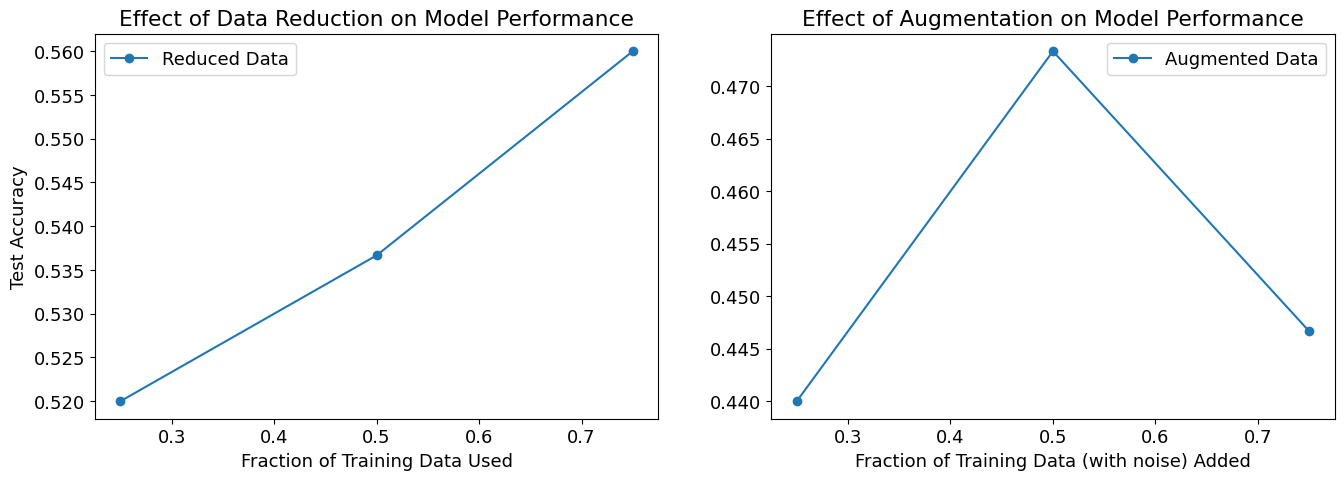

In [57]:
fig, AX = plt.subplots(1, 2, figsize=(16,5.))
ax = AX[0]
ax.plot(perc, accuracies, marker='o', label='Reduced Data')
ax.set_xlabel("Fraction of Training Data Used")
ax.set_title("Effect of Data Reduction on Model Performance")
ax.set_ylabel("Test Accuracy")
ax.legend()

ax=AX[1]
ax.plot(size_new_data, aug_accuracies, marker='o', label='Augmented Data')
ax.set_xlabel("Fraction of Training Data (with noise) Added")
ax.set_title("Effect of Augmentation on Model Performance")
ax.legend()

plt.show()

In [ ]:
# se vogliamo aggiungere rumore e basta (senza nuovi dati)
x_train_aug2 = add_noise(x_train)

y_train_aug2 = np.zeros(len(x_train_aug2))
for i in range(len(x_train_aug2)):
    y_train_aug2[i] = NF(x_train_aug2[i], B, TYPE)         # con o senza rumore? new_x_data o add_noise(new_x_data)?

aug_model2 = create_model(best_model['hyperparameters'])
aug_model2.fit(x_train_aug2, y_train_aug2, epochs=nepoch, batch_size=32, verbose=0)
aug_loss2, aug_acc2 = aug_model2.evaluate(x_test, y_test)
print(f"Augmented Data Accuracy: {round(aug_acc2, 3)}, Loss: {round(aug_loss2, 3)}")